We know the following, from the competition descrition.

**VARIABLE DESCRIPTIONS**:

- survival: Survival
    (0 = No; 1 = Yes)
- pclass: Passenger Class
    (1 = 1st; 2 = 2nd; 3 = 3rd)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of Siblings/Spouses Aboard
- parch: Number of Parents/Children Aboard
- ticket: Ticket Number
- fare: Passenger Fare
- cabin: Cabin
- embarked: Port of Embarkation
     (C = Cherbourg; Q = Queenstown; S = Southampton)

**SPECIAL NOTES**:

- Pclass is a proxy for socio-economic status (SES) -  1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5
- With respect to the family relation variables (i.e. `sibsp` and `parch`)
some relations were ignored.  The following are the definitions used
for `sibsp` and `parch`.

  - Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
  - Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
  - Parent:   Mother or Father of Passenger Aboard Titanic
  - Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore `parch=0` for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

# Notes

We don't have many data, so will use cross validation instead of a separate Validation set. This will give us a score not useful as a generalization error, but will use it anyway for selection (as it should be).

In [1]:
import pandas as pd
import numpy as np

test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')

## Simplifying final scoring via a downloaded version of survivors

Data comes from [http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets](), where some other data sets are available.

In [2]:
# There is an all empty record at the end
compiled_data = pd.read_csv('../input/titanic3.csv').dropna(how='all')

# The quotes in the names are wrong for `test.csv` and `train.csv`.
#  In general we don't care, so they are modified on the fly for the generation of the output test set
test_for_merger = test.copy()
test_for_merger['Name'] = test_for_merger['Name'].apply(lambda x: x.replace('"',''))
compiled_data['Name'] = compiled_data['name'].apply(lambda x: x.replace('"',''))

# We use both `Name` and `Ticket` to merge, because some passenger have duplicated names (we were getting wrong lengths before)
y_test = test_for_merger.merge(compiled_data, left_on=['Name', 'Ticket'], 
                    right_on=['Name', 'ticket'], how='left').rename(columns={'survived': 'Survived'})['Survived'].astype('int')

In [3]:
def generalization_error(prediction):
    print(((y_test - prediction) == 0).value_counts(normalize=True))

We will use the above data just to run the generalization error calculation, not for training, not for anything else.

In order to easily generate the CSV submission file when it is time to do so, we define the function below.

In [4]:
def csv_from_prediction(prediction, filename='submission.csv'):
    submission = pd.DataFrame(data={'PassengerId': test['PassengerId'], 'Survived': prediction.astype(int)})

    # This is what we do if we don't use 'index=False' below
    #submission.set_index('PassengerId', drop=True, inplace=True)
    submission.to_csv(filename, index=False)

Let's get our bases covered:

In [5]:
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.copy()

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [7]:
X_train['Embarked'].value_counts()
# We can see 'S' is the most common value

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Titles are collected from both sets, and ages set from global means

In [8]:
import re
titles = X_train['Name'].append(X_test['Name']).apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip()).unique()
titles = np.append(titles, ['High', 'Serving'])
#title_equivalences = {'Don': 'Mr', 'Dona': 'Mrs', 'Mlle': 'Miss', 'Mme': 'Mrs', 'Jonkheer': 'Lady', 'the Countess': 'Lady'}
title_equivalences = {'Don': 'Mr', 'Dona': 'Mrs', 'Mlle': 'Miss', 'Mme': 'Mrs',
                      'Jonkheer': 'High', 'the Countess': 'High', 'Lady': 'High',
                      'Col': 'High', 'Major': 'High', 'Sir': 'High',
                      'Capt': 'Serving', 'Rev': 'Serving', 'Dr': 'Serving'
                     }

X_train['Title'] = X_train['Name'].apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip())
X_test['Title'] = X_test['Name'].apply(lambda x: re.match('.*,([^\.]+)\..*', x)[1].strip())
for k,v in title_equivalences.items():
    X_train.loc[X_train['Title'] == k, 'Title'] = v
    X_test.loc[X_test['Title'] == k, 'Title'] = v
    
#title_mapping = {v: k for k, v in enumerate(title_mapping)}  # A Dict
#title_mapping['Mme'] = title_mapping['Mrs']
#title_mapping['Mlle'] = title_mapping['Miss']
#title_mapping['the Countess'] = title_mapping['Lady']
#title_mapping['Don'] = title_mapping['Mr']
#title_mapping['Dona'] = title_mapping['Mrs']
#inverse_title_mapping = {v: k for k, v in title_mapping.items()}  # The inverse Dict

In [44]:
ticket_sizes = (X_train['Ticket'].append(X_test['Ticket'])).value_counts()
        
def data_munge(data):
    useless_fields = ['PassengerId']
    data.drop(useless_fields, axis=1, inplace=True, errors='ignore')
    
    # This is the most common value
    data['Embarked'].fillna('S', inplace=True)
    
    data['GroupSize'] = data['Ticket'].apply(lambda x: ticket_sizes[x])
    data['NameLength'] = data['Name'].apply(lambda x: len(x))
    data['TicketLength'] = data['Ticket'].apply(lambda x: len(x))

    data['FamilyOnBoard'] = data['SibSp'] + data['Parch']
    data['FamilyOnBoardType'] = pd.cut(data['FamilyOnBoard'], np.array([0, 0.9, 1.9, 3.9, 100]),
       labels=["single","couple","small_family", "big_family"],
       include_lowest=True)
    data.drop('FamilyOnBoard', axis=1, inplace=True)
    
    data['CabinFirstLetter'] = data['Cabin'].apply(lambda x: x[0] if type(x)==str else '')
    data = pd.get_dummies(data, columns=['CabinFirstLetter']).drop(['Cabin', 'CabinFirstLetter_'], axis=1)
    
    data['Fare'] = data['Fare'].fillna(train['Fare'].mean())
    
    full_ages = X_train['Age'].append(X_test['Age'])
    full_titles = X_train['Title'].append(X_test['Title'])
    full_classes = X_train['Pclass'].append(X_test['Pclass'])
    for k in titles:
        for c in data['Pclass'].unique():
            mean_title_age = full_ages.loc[(full_titles == k) & (full_classes == c)].mean()
            data.loc[(data['Title'] == k) & data['Age'].isnull(), 'Age'] = mean_title_age

    data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Pclass', 'FamilyOnBoardType']) #.drop(['Sex_male', 'Embarked_C', 'Pclass_3'], axis=1)

    data['Kid'] = np.zeros(np.shape(data['Title']))
    data.loc[(data['Title'] == 'Master') & (data['Age'] <= 12), 'Kid'] = 1
    data.loc[(data['Title'] == 'Miss') & (data['Age'] <= 12), 'Kid'] = 1
    
    data['MumWithKid'] = np.zeros(np.shape(data['GroupSize']))
    data.loc[(data['Parch'] == 1) & (data['GroupSize'] == 3) & 
               (data['Sex_female'] == 1) & (data['Kid'] == 0), 'MumWithKid'] = 1

    
    # Titles and ages were already compiled globally, but the `Title` was not dummified (and won't be)
    data = pd.get_dummies(data, columns=['Title'])

    return data

In [46]:
X_train_ready = data_munge(X_train)

Mr 3 28.318910256410255
Mr 1 41.43984962406015
Mr 2 32.346715328467155
Mrs 3 32.326530612244895
Mrs 1 42.869565217391305
Mrs 2 33.51851851851852
Miss 3 17.36087378640777
Miss 1 30.131147540983605
Miss 2 20.71708333333333
Master 3 6.09
Master 1 6.984
Master 2 2.7572727272727273
Don 3 nan
Don 1 nan
Don 2 nan
Rev 3 nan
Rev 1 nan
Rev 2 nan
Dr 3 nan
Dr 1 nan
Dr 2 nan
Mme 3 nan
Mme 1 nan
Mme 2 nan
Ms 3 nan
Ms 1 nan
Ms 2 28.0
Major 3 nan
Major 1 nan
Major 2 nan
Lady 3 nan
Lady 1 nan
Lady 2 nan
Sir 3 nan
Sir 1 nan
Sir 2 nan
Mlle 3 nan
Mlle 1 nan
Mlle 2 nan
Col 3 nan
Col 1 nan
Col 2 nan
Capt 3 nan
Capt 1 nan
Capt 2 nan
the Countess 3 nan
the Countess 1 nan
the Countess 2 nan
Jonkheer 3 nan
Jonkheer 1 nan
Jonkheer 2 nan
Dona 3 nan
Dona 1 nan
Dona 2 nan
High 3 nan
High 1 48.1
High 2 nan
Serving 3 nan
Serving 1 49.666666666666664
Serving 2 40.7


# Simplest attempts (baselines)

A random assignment should give a 50% accuracy.

In [11]:
random_prediction = np.random.randint(0,2,len(y_train))
print("{:.2f}% of accuracy".format(1- abs(y_train - random_prediction).sum()/len(y_train)))
((y_train - random_prediction) == 0).value_counts(normalize=True)

0.48% of accuracy


False    0.516274
True     0.483726
Name: Survived, dtype: float64

A majority assignment should be better because the results are unbalanced, and that would be the benchmark to beat.

In [12]:
y_train.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [13]:
majority_prediction = np.full(len(y_train),0)
print("{:.2f}% of accuracy".format(1- abs(y_train - majority_prediction).sum()/len(y_train)))
((y_train - majority_prediction) == 0).value_counts(normalize=True)

0.62% of accuracy


True     0.616162
False    0.383838
Name: Survived, dtype: float64

# Process Test the same way

In [14]:
X_test_ready = data_munge(X_test)

In [15]:
X_test_ready.columns.values

array(['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'GroupSize',
       'NameLength', 'TicketLength', 'CabinFirstLetter_A',
       'CabinFirstLetter_B', 'CabinFirstLetter_C', 'CabinFirstLetter_D',
       'CabinFirstLetter_E', 'CabinFirstLetter_F', 'CabinFirstLetter_G',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'FamilyOnBoardType_single',
       'FamilyOnBoardType_couple', 'FamilyOnBoardType_small_family',
       'FamilyOnBoardType_big_family', 'Kid', 'MumWithKid', 'Title_High',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms',
       'Title_Serving'], dtype=object)

In [16]:
len(X_test_ready.columns)

37

In [17]:
len(X_train_ready.columns)

38

Just in case there are some columns in train that are not available in test, due to the dummification

In [18]:
for i in np.setdiff1d(X_train_ready.columns.values, X_test_ready.columns.values):
    X_test_ready[i] = 0

# Proper learning going on

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import export_graphviz
import graphviz

In [20]:
#features_ignored = ['Name', 'Title', 'Ticket', 'Parch', 'SibSp']
features_ignored = ['Name', 'Ticket', 'TicketLength', 'Parch', 'SibSp']
X_train_ready = X_train_ready.drop(features_ignored, axis=1)
X_test_ready = X_test_ready.drop(features_ignored, axis=1)

In [21]:
print(cross_val_score(DecisionTreeClassifier(), X_train_ready, y_train))
cross_val_score(RandomForestClassifier(n_estimators=10), X_train_ready, y_train).mean()

[ 0.71380471  0.75084175  0.79124579]


0.80920314253647596

In [22]:
cross_val_score(RandomForestClassifier(n_estimators=100, min_samples_split=19, min_samples_leaf=2),
                X_train_ready, y_train).mean()

0.82603815937149261

In [23]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=19, min_samples_leaf=2)
model.fit(X_train_ready, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=19, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [24]:
prediction = model.predict(X_test_ready)
generalization_error(prediction)
# I used to keep this result, but now it is quite bad (and it improved just by cleaning the notebook um??)

False    0.727273
True     0.272727
Name: Survived, dtype: float64


In [25]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_ready, y_train)
prediction = model.predict(X_test_ready)
generalization_error(prediction)

False    0.672249
True     0.327751
Name: Survived, dtype: float64


In [26]:
#tree_dot = export_graphviz(model.estimators_[1], out_file=None, feature_names=X_test.drop(['Name', 'Ticket', 'Cabin'], axis=1).columns, filled=True)
#graphviz.Source(tree_dot, format="png")

In [27]:
%%time
param_grid = { 'n_estimators': np.arange(20,200,20),
               'min_samples_leaf': np.arange(1, 5),
               'min_samples_split' : np.arange(4, 18,2),
               'max_depth': np.arange(4,6, 1)}

param_grid = { 'criterion': ['gini', 'entropy'],
               'n_estimators': [80],
               'min_samples_leaf': [3],
               'min_samples_split' : [6],
               'max_depth': [5]}
grid = GridSearchCV(RandomForestClassifier(warm_start=True, n_jobs=-1), param_grid=param_grid, cv=5)
grid.fit(X_train_ready, y_train)

CPU times: user 1.72 s, sys: 281 ms, total: 2 s
Wall time: 3.91 s


In [28]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

In [29]:
grid.best_score_

0.83389450056116721

In [30]:
prediction = grid.predict(X_train_ready)
((y_train - prediction) == 0).value_counts(normalize=True)

True     0.838384
False    0.161616
Name: Survived, dtype: float64

In [31]:
prediction = grid.predict(X_test_ready)
generalization_error(prediction)

False    0.729665
True     0.270335
Name: Survived, dtype: float64


Let's refit with the parameters identified:

In [32]:
rfc = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=50,
                             max_depth=4, max_features=5 ,
                             min_samples_leaf=1, min_samples_split=6)
rfc.fit(X_train_ready, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

In [33]:
prediction = rfc.predict(X_train_ready)
print(((y_train - prediction) == 0).value_counts(normalize=True))

True     0.837262
False    0.162738
Name: Survived, dtype: float64


In [34]:
#prediction = grid.predict(X_test.drop(features_ignored, axis=1))
#csv_from_prediction(prediction, filename='submission_tree_3.csv')

prediction = rfc.predict(X_test_ready)
csv_from_prediction(prediction, filename='submission_tree_4.csv')
generalization_error(prediction)

False    0.717703
True     0.282297
Name: Survived, dtype: float64


In [35]:
feature_importances = pd.DataFrame()
for est in rfc.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready.columns),
                             ignore_index=True)
feature_importances.mean().sort_values(ascending=False)

Title_Mrs                         0.193936
Embarked_C                        0.141663
Sex_male                          0.129021
Fare                              0.101932
Title_Mr                          0.057165
FamilyOnBoardType_single          0.054712
NameLength                        0.053026
Kid                               0.040982
Title_Ms                          0.040777
GroupSize                         0.038552
Age                               0.033302
Pclass_2                          0.032367
FamilyOnBoardType_big_family      0.016374
CabinFirstLetter_E                0.011344
Pclass_3                          0.009666
MumWithKid                        0.007502
FamilyOnBoardType_couple          0.005889
Pclass_1                          0.005541
Embarked_Q                        0.004838
CabinFirstLetter_B                0.003785
CabinFirstLetter_T                0.003399
Embarked_S                        0.003223
CabinFirstLetter_D                0.002888
Title_Miss 

Let's try with **two** decision trees, one per biological sex

In [36]:
X_train_ready_female = X_train_ready[X_train_ready['Sex_female'] == 1]
y_train_female = y_train[X_train_ready['Sex_female'] == 1]
X_train_ready_male = X_train_ready[X_train_ready['Sex_male'] == 1]
y_train_male = y_train[X_train_ready['Sex_male'] == 1]

In [37]:
rfc_female = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=50,
                             max_depth=4, max_features=5 ,
                             min_samples_leaf=1, min_samples_split=6)
rfc_female.fit(X_train_ready_female, y_train_female)

rfc_male = RandomForestClassifier(warm_start=True, n_jobs=-1,
                             n_estimators=50,
                             max_depth=4, max_features=5 ,
                             min_samples_leaf=1, min_samples_split=6)
rfc_male.fit(X_train_ready_male, y_train_male)

prediction = rfc_female.predict(X_train_ready_female)
print(((y_train_female - prediction) == 0).value_counts(normalize=True))
prediction = rfc_male.predict(X_train_ready_male)
print(((y_train_male - prediction) == 0).value_counts(normalize=True))

# Because of using two decision trees, we need to split our test per biological sex and then rejoin
X_test_ready_female = X_test_ready[X_test_ready['Sex_female'] == 1]
X_test_ready_male = X_test_ready[X_test_ready['Sex_male'] == 1]

prediction_female = rfc_female.predict(X_test_ready_female)
prediction_male = rfc_male.predict(X_test_ready_male)
result_female = X_test_ready_female.join(pd.Series(prediction_female, name='Survived', index=X_test_ready_female.index))
result_male = X_test_ready_male.join(pd.Series(prediction_male, name='Survived', index=X_test_ready_male.index))

# Now, let's join them and resort
prediction = result_female.append(result_male).sort_index()['Survived']
generalization_error(prediction)

#csv_from_prediction(prediction, filename='submission_dual_tree.csv')

True     0.812102
False    0.187898
Name: Survived, dtype: float64
True     0.856153
False    0.143847
Name: Survived, dtype: float64
True     0.763158
False    0.236842
Name: Survived, dtype: float64


In [38]:
errors = (X_test.join(pd.Series(prediction, name='Survived')))[(y_test - prediction) != 0]
errors[errors['Survived'] == 1]
#['Pclass'].value_counts()
print(X_train['Pclass'].value_counts(normalize=True))
print(X_test['Pclass'].value_counts(normalize=True))
errors['Pclass'].value_counts()
print("--- Survived per class (errors) ---")
print(errors['Pclass'].groupby(errors['Survived']).value_counts())
print("--- Family type per class (errors) ---")
print(errors['Pclass'].groupby(errors['FamilyOnBoardType']).value_counts())
print("--- Family type per survived (errors) ---")
print(errors['FamilyOnBoardType'].groupby(errors['Survived']).value_counts(normalize=True))
errors[errors['FamilyOnBoardType'] == 'single']

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64
3    0.521531
1    0.255981
2    0.222488
Name: Pclass, dtype: float64
--- Survived per class (errors) ---
Survived  Pclass
0         3         28
          1         17
          2          8
1         3         38
          2          6
          1          2
Name: Pclass, dtype: int64
--- Family type per class (errors) ---
FamilyOnBoardType  Pclass
single             3         42
                   1          9
                   2          8
couple             3          9
                   1          6
                   2          2
small_family       3          9
                   2          4
                   1          3
big_family         3          6
                   1          1
Name: Pclass, dtype: int64
--- Family type per survived (errors) ---
Survived  FamilyOnBoardType
0         single               0.641509
          couple               0.169811
          small_family         0.150943
      

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,GroupSize,NameLength,TicketLength,FamilyOnBoardType,CabinFirstLetter,Survived
5,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,Mr,1,26,4,single,,0
6,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,Miss,1,20,6,single,,1
37,3,"Cacic, Miss. Manda",female,21.0,0,0,315087,8.6625,NaN,S,Miss,1,18,6,single,,1
38,3,"Sap, Mr. Julius",male,25.0,0,0,345768,9.5000,NaN,S,Mr,1,15,6,single,,0
39,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S,Mr,8,13,4,single,,0
43,2,"Corbett, Mrs. Walter H (Irene Colvin)",female,30.0,0,0,237249,13.0000,NaN,S,Mrs,1,37,6,single,,1
46,1,"Chevre, Mr. Paul Romaine",male,45.0,0,0,PC 17594,29.7000,A9,C,Mr,1,24,8,single,A,0
57,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S,Mr,1,29,6,single,F,0
65,2,"Corey, Mrs. Percy C (Mary Phyllis Elizabeth Mi...",female,NaN,0,0,F.C.C. 13534,21.0000,NaN,S,Mrs,2,51,12,single,,1
66,3,"Burns, Miss. Mary Delia",female,18.0,0,0,330963,7.8792,NaN,Q,Miss,1,23,6,single,,1


<IPython.core.display.Javascript object>


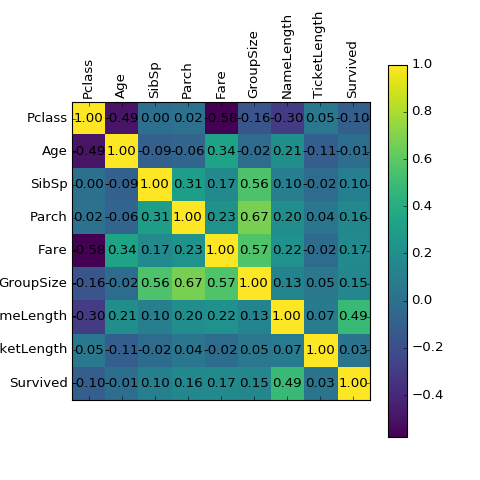

<IPython.core.display.Javascript object>


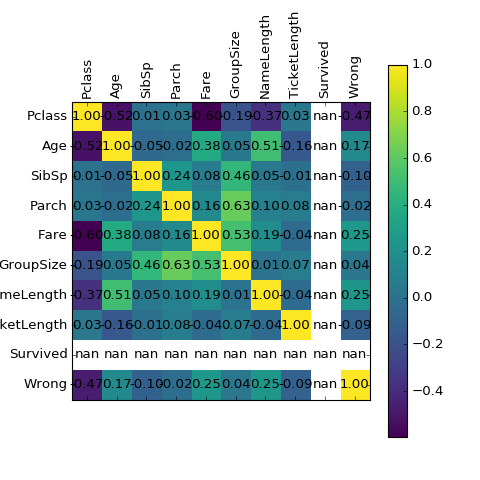

<IPython.core.display.Javascript object>


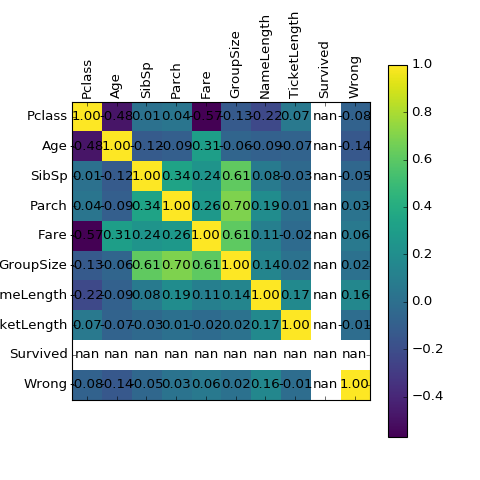

In [39]:
import matplotlib.pyplot as plt
%matplotlib notebook

full_x_test = X_test.join(pd.Series(prediction, name='Survived'))
corr = full_x_test.corr()
plt.matshow(corr, 
            interpolation='nearest', cmap=plt.cm.viridis, )
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation='vertical')
plt.colorbar()

for (i, j), z in np.ndenumerate(corr):
    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')

    
# Analyze what went wrong 
full_x_test_wrong = full_x_test.join(pd.Series(y_test - prediction, name='Wrong'))

corr_wrong = full_x_test_wrong[full_x_test_wrong['Survived'] == 1].corr()
plt.matshow(corr_wrong, 
            interpolation='nearest', cmap=plt.cm.viridis, )
plt.yticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns)
plt.xticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns, rotation='vertical')
plt.colorbar()

for (i, j), z in np.ndenumerate(corr_wrong):
    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')
    
corr_wrong = full_x_test_wrong[full_x_test_wrong['Survived'] == 0].corr()
plt.matshow(corr_wrong, 
            interpolation='nearest', cmap=plt.cm.viridis, )
plt.yticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns)
plt.xticks(np.arange(len(corr_wrong.columns)), corr_wrong.columns, rotation='vertical')
plt.colorbar()

for (i, j), z in np.ndenumerate(corr_wrong):
    plt.text(j, i, "{:.2f}".format(z), ha='center', va='center')

In [40]:
feature_importances = pd.DataFrame()
for est in rfc_female.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready.columns),
                             ignore_index=True)
print(feature_importances.mean().sort_values(ascending=False).head(10))

feature_importances = pd.DataFrame()
for est in rfc_male.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index= X_test_ready.columns),
                             ignore_index=True)
print(feature_importances.mean().sort_values(ascending=False).head(10))


FamilyOnBoardType_single    0.185335
GroupSize                   0.128458
Pclass_2                    0.124165
Fare                        0.110196
Kid                         0.097316
Pclass_3                    0.084244
Age                         0.066927
NameLength                  0.038589
Embarked_Q                  0.028739
MumWithKid                  0.021112
dtype: float64
Fare                            0.152941
Age                             0.131431
NameLength                      0.101770
Pclass_2                        0.084016
Title_Miss                      0.077088
MumWithKid                      0.076387
GroupSize                       0.061765
Kid                             0.051766
FamilyOnBoardType_big_family    0.051500
Title_Mrs                       0.047333
dtype: float64


# A visualization from a previous Random Forest Classifier

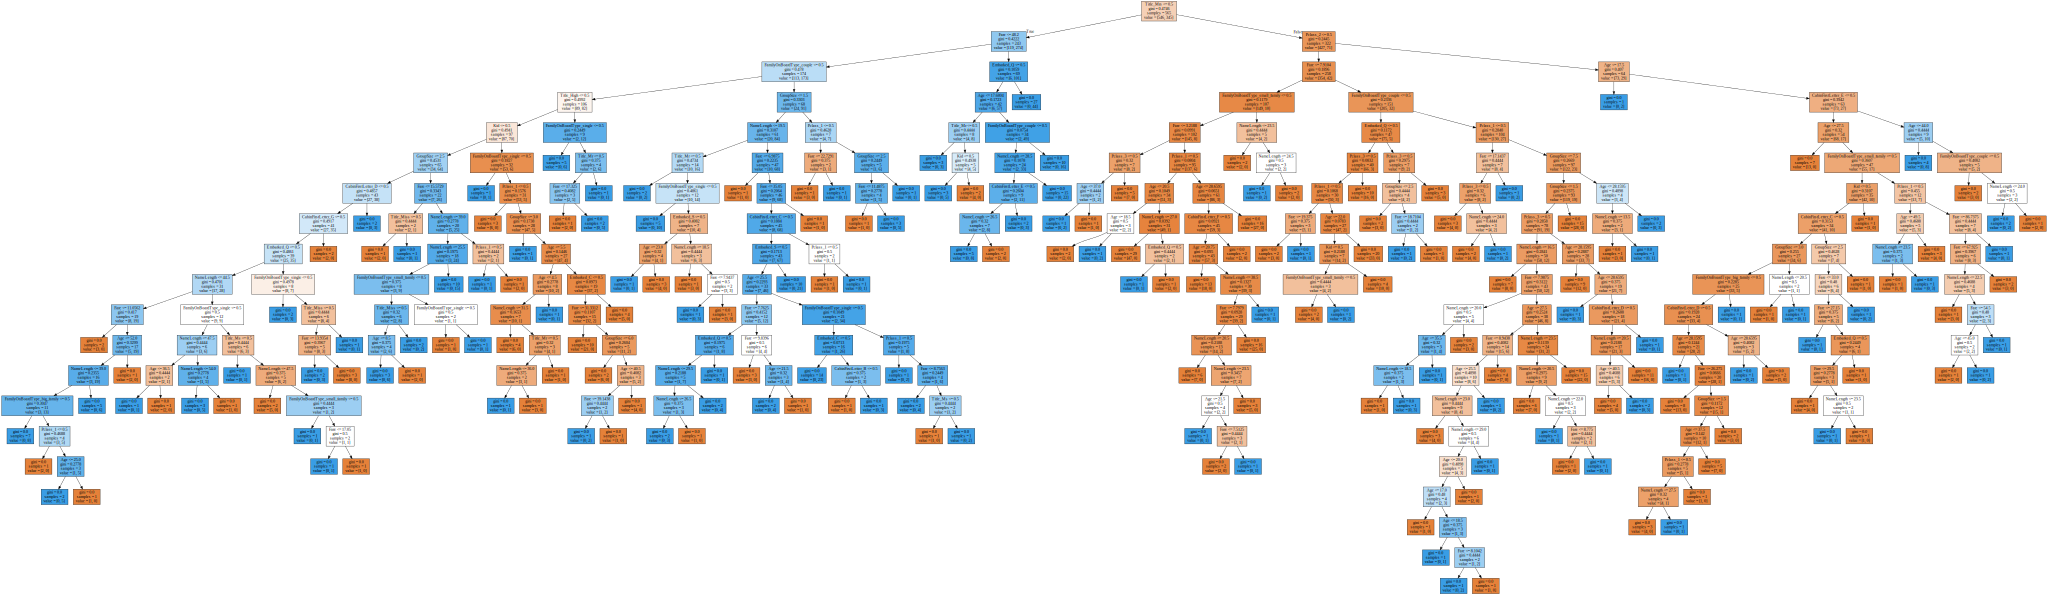

In [41]:
tree = export_graphviz(model.estimators_[11], out_file=None,
                       feature_names=X_test_ready.columns, filled=True)
graphviz.Source(tree, format="png")

In [42]:
feature_importances = pd.DataFrame()
for est in model.estimators_:
    feature_importances = feature_importances.append(pd.Series(est.feature_importances_, 
                                        index=X_test_ready.columns),
                             ignore_index=True)

In [43]:
feature_importances.mean().sort_values(ascending=False)

Age                               0.148565
NameLength                        0.143551
Fare                              0.138864
Embarked_C                        0.080627
Title_Mrs                         0.073590
Sex_male                          0.072878
GroupSize                         0.051312
FamilyOnBoardType_single          0.040840
Title_Ms                          0.032402
Title_Mr                          0.029280
Pclass_2                          0.022570
Kid                               0.021332
Pclass_1                          0.015079
FamilyOnBoardType_big_family      0.014803
Pclass_3                          0.012458
Embarked_Q                        0.011646
FamilyOnBoardType_couple          0.011154
CabinFirstLetter_E                0.010586
MumWithKid                        0.009557
FamilyOnBoardType_small_family    0.008622
CabinFirstLetter_C                0.008052
Title_Miss                        0.007866
Embarked_S                        0.007320
CabinFirstL